<a href="https://colab.research.google.com/github/vcepaitis/SSI_EF2_2023/blob/main/VAEVilius.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.transforms import Normalize
from copy import deepcopy

from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Try to get the gpu, if available
if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    print("Using MPS")
    device = torch.device("mps")
    x = torch.ones(1, device=device)
else:
    print ("MPS or CUDA device not found. Reverting to CPU")
    device = torch.device("cpu")

Using GPU


In [4]:
def log_transform(x):
    return torch.log10(x+0.01) + 2

def inverse_log_transform(x):
    return 10 ** (x - 2) - 0.01

In [5]:
input_directory = os.path.join('drive/MyDrive', 'Data-MLtutorial/JetDataset/')

# Get a list of all h5 files in the directory
h5_files = [file for file in os.listdir(input_directory) if file.endswith('.h5')]

# Lists to store data
all_images = []
all_targets = []

for h5_file in h5_files:
    file_path = os.path.join(input_directory, h5_file)

    with h5py.File(file_path, 'r') as f:
        images = np.array(f['jetImage'], dtype=np.float32)
        images = torch.from_numpy(images)
        images = torch.unsqueeze(images, dim=1)  # add extra dim, needed for CNN
        # transform
        images = log_transform(images)
        all_images.append(images)

        jet_data = np.array(f['jets'])
        targets = torch.from_numpy(jet_data[:, -6:-1])
        all_targets.append(targets)

# Stack all images and targets from different files
stacked_images = torch.cat(all_images, dim=0)
stacked_targets = torch.cat(all_targets, dim=0)

print("Stacked images shape:", stacked_images.shape)
print("Stacked targets shape:", stacked_targets.shape)

stacked_images = stacked_images
vmax = torch.max(stacked_images)

Stacked images shape: torch.Size([80000, 1, 100, 100])
Stacked targets shape: torch.Size([80000, 5])


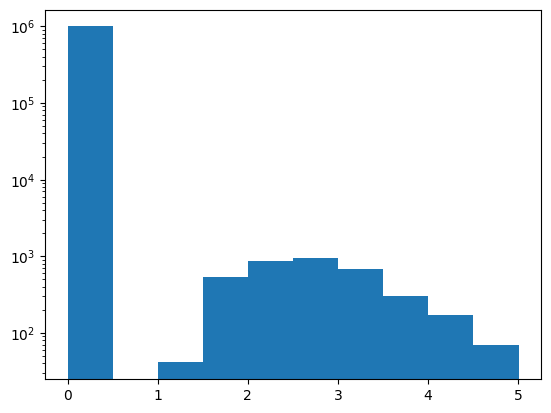

In [6]:
plt.hist(torch.flatten(stacked_images[:100]))
plt.yscale('log')
plt.show()

In [7]:
# Create training and test dataloaders

# how many samples per batch to load
batch_size = 100

# Create a TensorDataset from images and targets
dataset = torch.utils.data.TensorDataset(stacked_images, stacked_targets)

# Calculate the number of samples in the dataset
dataset_size = len(dataset)

# Define the portion of data to allocate for training
train_ratio = 0.8  # For example, use 80% for training

# Calculate the number of samples for training and testing
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [13]:
class Encoder(nn.Module):
    def __init__(self, ndim=8):
        super(Encoder, self).__init__()

        ## encoder layers ##
        ## baseline: 16x2
        self.conv1 = nn.Conv2d(1, ndim, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(ndim, ndim*2, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(ndim*2, ndim*4, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(ndim*4, ndim*8, 3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(ndim*8, ndim*16, 3, stride=2, padding=1)
        self.conv6 = nn.Conv2d(ndim*16, ndim*32, 3, stride=2, padding=1)

        self.flatten = nn.Flatten()

    def forward(self, x):
        # Three CNN layers and then flatten
        x = F.relu(self.conv1(x))
        #print(f"First layer shape: {x.shape}")
        x = F.relu(self.conv2(x))
        #print(f"Second layer shape: {x.shape}")
        x = F.relu(self.conv3(x))
        #print(f"Third layer shape: {x.shape}")
        x = F.relu(self.conv4(x))
        #print(f"Fourth layer shape: {x.shape}")
        # x = F.relu(self.conv5(x))
        #print(f"Fifth layer shape: {x.shape}")
       #  x = F.relu(self.conv6(x))
        #print(f"Sixth layer shape: {x.shape}")

        x = self.flatten(x)
        return x


class Decoder(nn.Module):
    def __init__(self, ndim=8):
        super(Decoder, self).__init__()

        ## decoder layers ##
        ## 64x13x13->32x25x25->16x50x50->1x100x100
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(ndim*8, 7, 7))
        self.deconv1 = nn.ConvTranspose2d(ndim*32, ndim*16, 3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(ndim*16, ndim*8, 3, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(ndim*8, ndim*4, 3, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(ndim*4, ndim*2, 3, stride=2, padding=1)
        self.deconv5 = nn.ConvTranspose2d(ndim*2, ndim, 3, stride=2, padding=1, output_padding=1)
        self.deconv6 = nn.ConvTranspose2d(ndim, 1, 3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        ## Unflatten and then three inverse CNN layers
        x = self.unflatten(x)
        # x = F.relu(self.deconv1(x))
        #print(f"First layer shape: {x.shape}")
        # x = F.relu(self.deconv2(x))
        #print(f"Second layer shape: {x.shape}")
        x = F.relu(self.deconv3(x))
        #print(f"Third layer shape: {x.shape}")
        x = F.relu(self.deconv4(x))
        #print(f"Fourth layer shape: {x.shape}")
        x = F.relu(self.deconv5(x))
        #print(f"Fifth layer shape: {x.shape}")
        x = F.relu(self.deconv6(x))
        #print(f"Fifth layer shape: {x.shape}")


        return x


# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self, device="cpu", nhidden=8, ndim=16):
        # Let user specify the latent dimensionality
        super(ConvAutoencoder, self).__init__()
        self.encoder = Encoder(ndim)
        self.decoder = Decoder(ndim)
        nflat = 8 * ndim * 7 * 7
        self.fce = nn.Linear(nflat, nhidden)
        self.fcd = nn.Linear(nhidden, nflat)
        self.to(device)


    def forward(self, x):
        x = self.encoder(x)
        x = self.fce(x)

        x = self.fcd(x)
        x = self.decoder(x)
        # Return two blank outputs for consistency with VAE
        return x, _, _


class ConvVariationalAutoencoder(ConvAutoencoder):
    def __init__(self, device="cpu", nhidden=100, ndim=16):
        super(ConvVariationalAutoencoder, self).__init__(device, nhidden, ndim)
        # need two identical fc layers
        self.fce2 = deepcopy(self.fce)
        self.device = device


    # Reparametrisation trick to allow training via backpropagation
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    # Bottleneck/latent layer
    def bottleneck(self, h):
        mu, logvar = self.fce(h), self.fce2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    # Helper function, useful for generating outputs later on
    def generate(self, x):
        x = self.fcd(x)
        x = self.decoder(x)
        return x

    def forward(self, x):
        # pass data through encoder
        x = self.encoder(x)

        # pass through bottleneck layer
        z, mu, logvar = self.bottleneck(x)

        # unflatten the data and decode
        x = self.generate(z)

        return x, mu, logvar

In [27]:
# initialize the NN
type = "VAE"
nhidden = 300
ndim = 16
model = None
if type == "AE":
    model = ConvAutoencoder(nhidden=nhidden, device=device, ndim=ndim)
elif type == "VAE":
    model = ConvVariationalAutoencoder(nhidden=nhidden, device=device, ndim=ndim)
else:
    print("Invalid type chosen!")
    print(invalid)
# was 100 before

total_params = sum(p.numel() for p in model.parameters())
print(f"Model has {total_params} parameters")

loss_fn_bce = nn.MSELoss(reduction='sum')

def loss_fn(inputs, x, mu, logvar):
    BCE = loss_fn_bce(inputs, x)
    if type == "AE":
        return BCE, 0, 0 # for AE case
    elif type == "VAE":
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        beta = 1
        return BCE + beta*KLD, BCE, KLD
    else:
        print(stop)

# specify loss function
# criterion = nn.MSELoss()

# specify the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# schedule the learning rate decay
# decay by gamma every step_size
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.90)

Model has 8796121 parameters


In [ ]:
# number of epochs to train the model
n_epochs = 50
train_losses = []
test_losses = []

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    test_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, labels in train_loader:
        data = data.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(data)
        # calculate the loss
        # loss = criterion(outputs[0], data)
        loss, _, _ = loss_fn(data, *outputs)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)


    ###################
    # test the model #
    ###################
    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(data)
            # calculate the loss
            loss, _, _ = loss_fn(data, *outputs)
            # loss = criterion(outputs[0], data)
            # update running training loss
            test_loss += loss.item() * data.size(0)


    # print avg training statistics
    train_loss = train_loss/len(train_loader)
    train_losses.append(train_loss)
    test_loss = test_loss/len(test_loader)
    test_losses.append(test_loss)

    print('Epoch: {} \tTrain loss: {:.4g} \tTest Loss: {:.4g}\tLearning rate: {:.3g}'.format(
        epoch,
        train_loss,
        test_loss,
        scheduler.get_last_lr()[0]
        ))
    scheduler.step()

Epoch: 1 	Train loss: 2.86e+06 	Test Loss: 2.845e+06	Learning rate: 0.001
Epoch: 2 	Train loss: 2.86e+06 	Test Loss: 2.845e+06	Learning rate: 0.001
Epoch: 3 	Train loss: 2.86e+06 	Test Loss: 2.845e+06	Learning rate: 0.001
Epoch: 4 	Train loss: 2.86e+06 	Test Loss: 2.845e+06	Learning rate: 0.0009
Epoch: 5 	Train loss: 2.86e+06 	Test Loss: 2.845e+06	Learning rate: 0.0009


In [ ]:
# Target loss: <1.8e+06 with no KL-term
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()

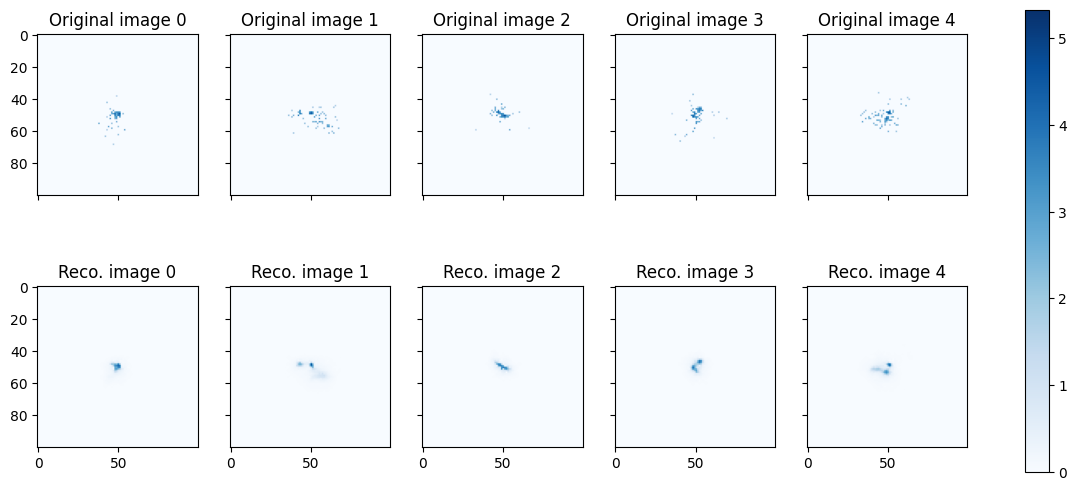

In [25]:
def plot_image(ax, image):
    return ax.imshow(np.squeeze(image), vmin=0, vmax=vmax, cmap=cm.Blues)
n_images = 5
# obtain one batch of test images
dataiter = iter(test_loader)
test_images, _ = next(dataiter)
test_images = test_images[:n_images].to(device)

# get sample outputs
output = model(test_images)
# prep images for display
test_images = test_images.cpu()
# use detach when it's an output that requires_grad
output = output[0].detach().cpu()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(n_images*3,6))
# input images on top row, reconstructions on bottom
for i, (input, output) in enumerate(zip(test_images, output)):
    input = input.numpy()
    output = output.numpy()
    in_img = plot_image(axes[0, i], input)
    axes[0, i].set_title(f'Original image {i}')
    out_img = plot_image(axes[1, i], output)
    axes[1, i].set_title(f'Reco. image {i}')

fig.colorbar(in_img, ax=axes.ravel().tolist())

plt.savefig('reco.png')
plt.savefig('reco.pdf')
plt.show()


AttributeError: ignored

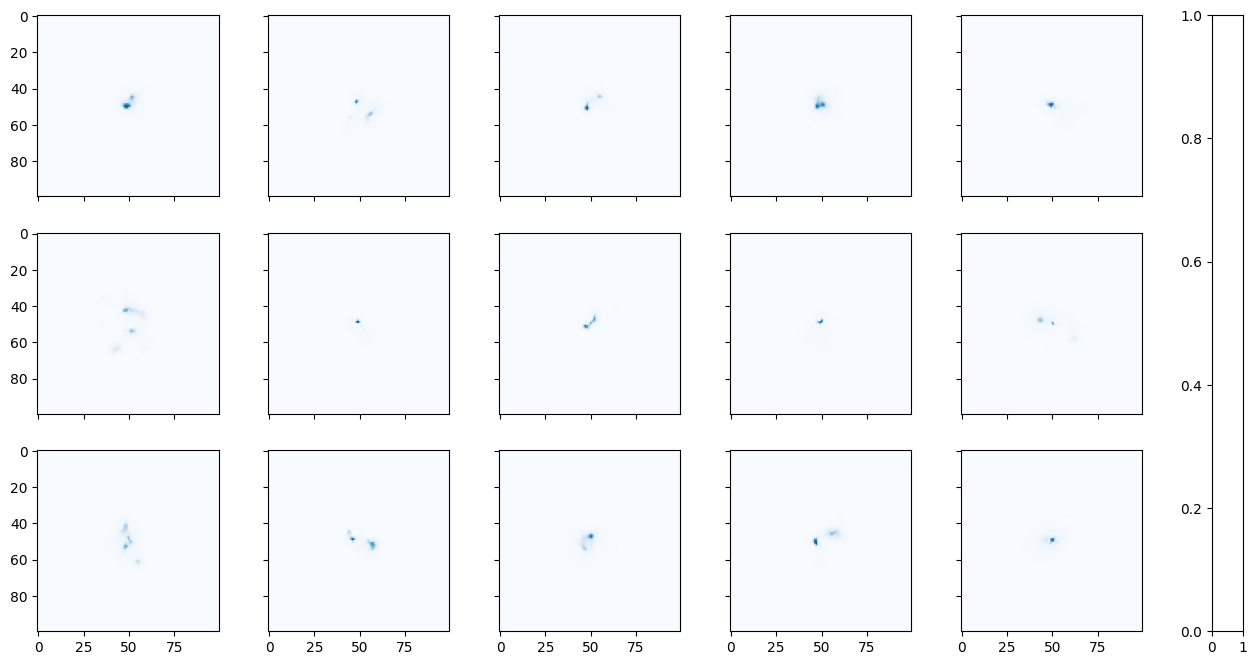

In [26]:
# Plot generated images
n_gen = 5*3
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(6*3,8), sharex=True, sharey=True)
z = torch.randn(n_gen, nhidden).to(device)
samples = model.generate(z)
samples = samples.detach().cpu().numpy()
for ax, sample in zip(axes.flatten(), samples):
    plot_image(ax, sample)
fig.colorbar(sample, ax=axes.ravel().tolist())
fig.suptitle("Generated images")
plt.savefig('gen.png')
plt.savefig('gen.pdf')
plt.show()
